# Estimation of covariance matrices

In [25]:
import math
import numpy as np
import matplotlib.pyplot as plt

from covariance.analytical_shrinkage import AnalyticalShrinkage
from covariance.linear_shrinkage import LinearShrinkage
from covariance.estimator import SampleEstimator, FSOptEstimator, EmpiricalBayesianEstimator
from covariance.metrics import loss_mv, loss_frobenius, PRIAL_mv

In [66]:
analshr = AnalyticalShrinkage()
linshr = LinearShrinkage()
sample_est = SampleEstimator()
eb_est = EmpiricalBayesianEstimator

## Sampling random population covariance matrix (Sigma)

#### First, let's build a method to sample orthogonal random matrices

In [10]:
def sample_rand_orthogonal_mtx(n):
    # n by n random complex matrix
    X = np.random.randn(n,n)
    # orthonormalizing matrix using QR algorithm
    Q,_ = np.linalg.qr(X)
    return Q

In [18]:
M = sample_rand_orthogonal_mtx(5) 
np.round(np.matmul(M, M.T), 12)

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -0., -0.],
       [ 0.,  0., -0.,  1.,  0.],
       [ 0.,  0., -0.,  0.,  1.]])

#### Now, let's sample a diagonal matrix with a certain proportion of eigenvalues

In [36]:
def sample_diagEig_mtx(p):
    ONE_PROP = 0.2    # proportion of eigenvalues equal to one
    THREE_PROP = 0.4  # proportion of eigenvalues equal to three
    TEN_PROP = 0.4    # proportion of eigenvalues equal to ten

    n_one = math.ceil(p * ONE_PROP)       # number of eigenvalues equal to one
    n_three = math.floor(p * THREE_PROP)  # number of eigenvalues equal to three
    n_ten = p - n_one - n_three           # number of eigenvalues equal to ten

    # building eigenvalues
    one_eigs = [1.0]*n_one
    three_eigs = [3.0]*n_three
    ten_eigs = [10.0]*n_ten
    # concatenating eigenvalues lists
    eigs = one_eigs + three_eigs + ten_eigs
    # shuffling eigenvalues
    np.random.shuffle(eigs)
    # building diagonal matrix
    M = np.diag(eigs)
    return M

In [45]:
sample_diagEig_mtx(5)

array([[ 3.,  0.,  0.,  0.,  0.],
       [ 0., 10.,  0.,  0.,  0.],
       [ 0.,  0.,  3.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0., 10.]])

#### to create a random population matrix (not necessarily diagonal) we use both functions

In [51]:
def sample_pop_cov(p, diag=False):
    if diag:
        return sample_diagEig_mtx(p)
    else:
        O = sample_rand_orthogonal_mtx(p)
        M = sample_diagEig_mtx(p)
        # O M O.T preserves original eigenvalues (O is an orthogonal rotation)
        return np.matmul(np.matmul(O, M), O.T) # sampling \Sigma

In [53]:
Sigma = sample_pop_cov(5)
np.linalg.eigvals(Sigma)

array([ 1., 10., 10.,  3.,  3.])

## Sampling dataset using population covariance matrix (Sigma)

In [62]:
p, n = 5, 10

Sigma = sample_pop_cov(p)
X = np.random.multivariate_normal(np.random.randn(p), Sigma, size=n)
print('Shape:', X.shape)
print('Random generated dataset:\n', X)

Shape: (10, 5)
Random generated dataset:
 [[-2.55854161 -0.21032277  0.34164514  1.74807977 -1.92248937]
 [ 4.05721814  0.57437241 -1.80716247 -3.64794955  4.3723337 ]
 [-3.49631905  0.51208678 -2.36383886 -0.04511112  2.13134723]
 [-5.39668058 -2.34351835 -0.19474646  2.27195219 -2.28249785]
 [-5.17591679 -0.56141896  3.13210634  2.92909646 -1.47376948]
 [-3.07709575 -1.3481458   1.1436639   0.45434139 -1.44333464]
 [ 0.99716777 -0.60400778 -1.24983323  1.133208    2.45073637]
 [ 1.51870019 -0.53705     3.01233139 -0.74123213  1.68977933]
 [-4.57658339 -1.42730276 -0.28265274  1.26742946  1.54039592]
 [-2.68474052  5.64446152  1.1995579   0.24871691  3.17230273]]


## Testing estimators and metrics

In [64]:
p, n = 200, 600

Sigma = sample_pop_cov(p)
X = np.random.multivariate_normal(np.random.randn(p), Sigma, size=n)
print('Shape:', X.shape)

Shape: (600, 200)


In [73]:
Sample = sample_est.estimate(X)
print('S sample estim. shape:', Sample.shape)

S sample estim. shape: (200, 200)


In [69]:
fsopt_est = FSOptEstimator(Sigma)
S_star = fsopt_est.estimate(X)
print('S_star shape:', S_star.shape)

S_star shape: (200, 200)


### Checking that PRIAL(Sample) = 0%

In [79]:
E_Sn = loss_mv(Sigma_tilde=Sample, Sigma=Sigma)
E_Sigma_tilde = loss_mv(Sigma_tilde=Sample, Sigma=Sigma)
E_Sstar = loss_mv(Sigma_tilde=S_star, Sigma=Sigma)

PRIAL_mv(E_Sn=E_Sn, E_Sigma_tilde=E_Sigma_tilde, E_Sstar=E_Sstar)

0.0

### Checking that PRIAL(S_star) = 100%

In [77]:
E_Sn = loss_mv(Sigma_tilde=Sample, Sigma=Sigma)
E_Sigma_tilde = loss_mv(Sigma_tilde=S_star, Sigma=Sigma)
E_Sstar = loss_mv(Sigma_tilde=S_star, Sigma=Sigma)

PRIAL_mv(E_Sn=E_Sn, E_Sigma_tilde=E_Sigma_tilde, E_Sstar=E_Sstar)

1.0

#### After these tests we are more confident that estimators FSOptEstimator and SampleEstimator, as well as metrics loss_mv and PRIAL_mv, are working properly

# Monte Carlo simulations

In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt

from covariance.analytical_shrinkage import AnalyticalShrinkage
from covariance.linear_shrinkage import LinearShrinkage
from covariance.estimator import SampleEstimator, FSOptEstimator, EmpiricalBayesianEstimator
from covariance.metrics import loss_mv, loss_frobenius, PRIAL_mv

In [36]:
def sample_rand_orthogonal_mtx(n):
    # n by n random complex matrix
    X = np.random.randn(n,n)
    # orthonormalizing matrix using QR algorithm
    Q,_ = np.linalg.qr(X)
    return Q

In [4]:
def sample_diagEig_mtx(p):
    ONE_PROP = 0.2    # proportion of eigenvalues equal to one
    THREE_PROP = 0.4  # proportion of eigenvalues equal to three
    TEN_PROP = 0.4    # proportion of eigenvalues equal to ten

    n_one = math.ceil(p * ONE_PROP)       # number of eigenvalues equal to one
    n_three = math.floor(p * THREE_PROP)  # number of eigenvalues equal to three
    n_ten = p - n_one - n_three           # number of eigenvalues equal to ten

    # building eigenvalues
    one_eigs = [1.0]*n_one
    three_eigs = [3.0]*n_three
    ten_eigs = [10.0]*n_ten
    # concatenating eigenvalues lists
    eigs = one_eigs + three_eigs + ten_eigs
    # shuffling eigenvalues
    np.random.shuffle(eigs)
    # building diagonal matrix
    M = np.diag(eigs)
    return M

In [5]:
def sample_pop_cov(p, diag=False):
    if diag:
        return sample_diagEig_mtx(p)
    else:
        O = sample_rand_orthogonal_mtx(p)
        M = sample_diagEig_mtx(p)
        # O M O.T preserves original eigenvalues (O is an orthogonal rotation)
        return np.matmul(np.matmul(O, M), O.T) # sampling \Sigma

In [6]:
def sample_dataset(p, n, Sigma=None):
    if Sigma is None:
        Sigma = sample_pop_cov(p)
    X = np.random.multivariate_normal(np.random.randn(p), Sigma, size=n)
    return X, Sigma

In [43]:
def run_simulation(p, n, estimators, nreps=100):
    Sn_idx = 0
    Sstar_idx = 1
    Sigma_tilde_idx = 2

    Sigma = sample_pop_cov(p)
    sample_est = SampleEstimator()
    fsopt_est = FSOptEstimator(Sigma)

    LOSSES = np.zeros((len(estimators), 3))
    PRIALS = np.zeros(len(estimators))
    TIMES = np.zeros((len(estimators)))

    for (idx, estimator) in enumerate(estimators):
        t1 = time.time()
        for i in range(nreps):
            # sampling random dataset from fixed population covariance matrix
            X, _ = sample_dataset(p=p, n=n, Sigma=Sigma)
            # estimating sample cov
            Sample = sample_est.estimate(X)
            # estimating S_star
            S_star = fsopt_est.estimate(X)
            # estimating population covariance matrix using current estimator
            if isinstance(estimator, FSOptEstimator):
                estimator.set_Sigma(Sigma)
            Sigma_tilde = estimator.estimate(X)
            # calculating losses
            loss_Sn = loss_mv(Sigma_tilde=Sample, Sigma=Sigma)
            loss_Sstar = loss_mv(Sigma_tilde=S_star, Sigma=Sigma)
            loss_Sigma_tilde = loss_mv(Sigma_tilde=Sigma_tilde, Sigma=Sigma)
            LOSSES[idx][Sn_idx] += loss_Sn
            LOSSES[idx][Sstar_idx] += loss_Sstar
            LOSSES[idx][Sigma_tilde_idx] += loss_Sigma_tilde
        t2 = time.time()
        TIMES[idx] = (t2-t1)*1000/nreps # time needed in ms (meaned by number of repetitions)
        LOSSES[idx] /= p
        PRIALS[idx] = PRIAL_mv(E_Sn=LOSSES[idx][Sn_idx],
                               E_Sigma_tilde=LOSSES[idx][Sigma_tilde_idx],
                               E_Sstar=LOSSES[idx][Sstar_idx])
        
    return LOSSES, PRIALS, TIMES


In [87]:
def run_graphic_simulation(estimators, labels, P_list=[5, 50, 100, 150, 200, 300, 400, 500],
                           N=None, ratio=3, nreps=None, metric='prial'):

    MEASURES = np.zeros((len(P_list), len(estimators)))

    ratios = []

    for (idx, p) in enumerate(P_list):
        if N is None:
            n = ratio*p
        else:
            n = N
            ratios.append(p/n)
        if nreps is None:
            nreps = int(max(100, min(1000, 10000/p)))

        losses, prials, times = run_simulation(p, n, estimators, nreps=nreps)
        if metric == 'prial':
            MEASURES[idx] = prials
        elif metric == 'loss':
            MEASURES[idx] = losses
        elif metric == 'time':
            MEASURES[idx] = times

    if N is None:
        lines = plt.plot(P_list, MEASURES, '-D')
        plt.xlabel('Matrix dimension p')
    else:
        lines = plt.plot(ratios, MEASURES, '-D')
        plt.xlabel('Ratio p/n')
    plt.legend(lines, labels)

    if metric == 'prial':
        plt.title('Evolution of PRIAL (reps='+str(nreps)+')')
        plt.ylabel('PRIAL')
    elif metric == 'loss':
        plt.title('Evolution of Loss (reps='+str(nreps)+')')
        plt.ylabel('Loss')
    elif metric == 'time':
        plt.title('Duration study on average (reps='+str(nreps)+')')
        plt.ylabel('time (ms)')


In [72]:
analshr = AnalyticalShrinkage()
linshr = LinearShrinkage()
sample_est = SampleEstimator()
fsopt_est = FSOptEstimator(None)
estimators = [analshr, linshr, sample_est, fsopt_est]

LOSSES, PRIALS, _ = run_simulation(p=200, n=600, estimators=estimators, nreps=100)
print("===== LOSSES =====")
# Sigma_tilde_idx = 2
print("\t Analytical average loss:", LOSSES[0][2])
print("\t Linear average loss:", LOSSES[1][2])
print("\t Sample est. average loss:", LOSSES[2][2])
print("\t FSOpt est. average loss:", LOSSES[3][2])
print("===== PRIALS =====")
print("\t Analytical PRIAL:", PRIALS[0])
print("\t Linear PRIAL:", PRIALS[1])
print("\t Sample est. PRIAL:", PRIALS[2])
print("\t FSOpt est. PRIAL:", PRIALS[3])

===== LOSSES =====
	 Analytical average loss: 0.37930131067631123
	 Linear average loss: 0.5238105294140358
	 Sample est. average loss: 0.6802290291955803
	 FSOpt est. average loss: 0.37183383004853143
===== PRIALS =====
	 Analytical PRIAL: 0.972381662739618
	 Linear PRIAL: 0.504842078868893
	 Sample est. PRIAL: 0.0
	 FSOpt est. PRIAL: 1.0


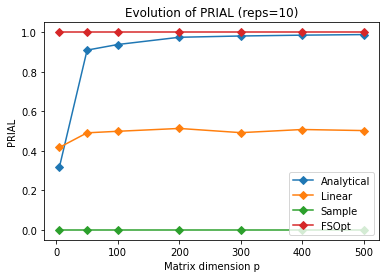

In [78]:
analshr = AnalyticalShrinkage()
linshr = LinearShrinkage()
sample_est = SampleEstimator()
fsopt_est = FSOptEstimator(None)
estimators = [analshr, linshr, sample_est, fsopt_est]
labels = ['Analytical', 'Linear', 'Sample', 'FSOpt']
P_list = [5, 50, 100, 200, 300, 400, 500]

run_graphic_simulation(estimators, labels, P_list=P_list, ratio=3, nreps=10, metric='prial')

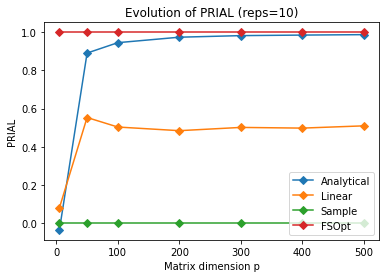

In [82]:
run_graphic_simulation(estimators, labels, P_list=P_list, ratio=3, nreps=10, metric='prial')

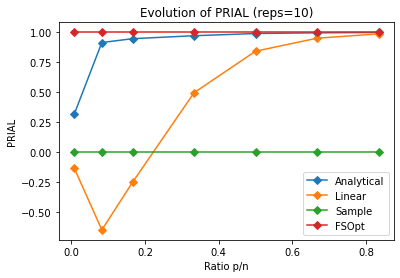

In [88]:
run_graphic_simulation(estimators, labels, P_list=P_list, N=600, nreps=10, metric='prial')

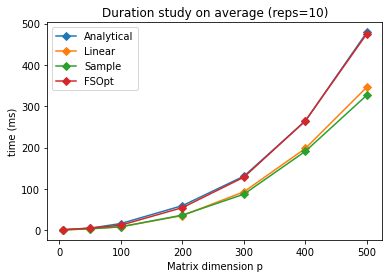

In [93]:
run_graphic_simulation(estimators, labels, P_list=P_list, ratio=3, nreps=10, metric='time')

### Let's execute simulations with a greater amount of repetitions

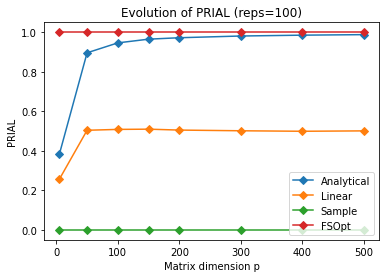

In [96]:
analshr = AnalyticalShrinkage()
linshr = LinearShrinkage()
sample_est = SampleEstimator()
fsopt_est = FSOptEstimator(None)
estimators = [analshr, linshr, sample_est, fsopt_est]
labels = ['Analytical', 'Linear', 'Sample', 'FSOpt']
# P_list = [5, 50, 100, 150, 200, 300, 400, 500]
run_graphic_simulation(estimators, labels, ratio=3, nreps=100, metric='prial')

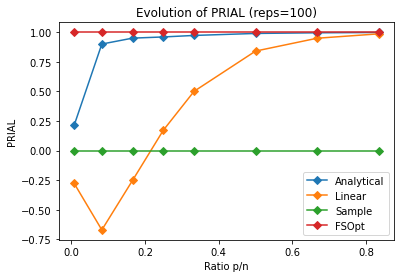

In [97]:
run_graphic_simulation(estimators, labels, N=600, nreps=100, metric='prial')

In [ ]:
run_graphic_simulation(estimators, labels, ratio=3, nreps=100, metric='time')